In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import spacy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_tweedie_deviance

In [120]:
df=pd.read_csv("Train.csv")
df= df.dropna()
df

Date    Category   Brand  Day_of_Week  Holiday_Indicator  \
0      26/09/24  Automotive  BrandA            3                  0   
1      26/09/24  Automotive  BrandA            3                  0   
2      26/09/24  Automotive  BrandA            3                  0   
3      26/09/24  Automotive  BrandA            3                  0   
4      22/09/24  Automotive  BrandA            6                  1   
...         ...         ...     ...          ...                ...   
18478  18/02/21        Toys  BrandF            3                  0   
18479  10/02/21        Toys  BrandF            2                  0   
18480  02/02/21        Toys  BrandF            1                  0   
18481  25/01/21        Toys  BrandF            0                  0   
18482  21/01/21        Toys  BrandF            3                  0   

       Past_Purchase_Trends   Price  Discount  Competitor_Price  \
0                      17.9  462.30     33.96            359.45   
1                      66.3  321.28     24.76             49.47   
2                      14.4   74.85     32.19            245.11   
3                      34.7  469.12     43.68            144.08   
4                      93.5  221.76     36.79            478.07   
...                     ...     ...       ...               ...   
18478                  22.0  266.55     18.33            383.05   
18479                  48.4  481.87     23.41            469.83   
18480                  50.7  123.81     46.73            214.11   
18481                  73.4   77.95     10.07             82.28   
18482                   5.1  473.60      6.21            427.60   

       Sales_Quantity  
0               227.0  
1               370.0  
2               299.0  
3               426.0  
4               470.0  
...               ...  
18478           359.0  
18479           333.0  
18480           132.0  
18481           274.0  
18482           350.0  

[18019 rows x 10 columns]

In [121]:
day=60*60*24
year=365.2425*day

In [122]:
df["Date"] = pd.to_datetime(df["Date"], format='%d/%m/%y')
df["Seconds"]=df.Date.map(pd.Timestamp.timestamp)
df["day_sine"]=np.sin(df["Seconds"]*(2*np.pi/day))
df["year_sine"]=np.cos(df["Seconds"]*(2*np.pi/year))

In [123]:
from sklearn.preprocessing import LabelEncoder

label_encoder1 = LabelEncoder()
label_encoder2 = LabelEncoder()
df['Category_encoded'] = label_encoder1.fit_transform(df['Category'])
df['Brand_encoded'] = label_encoder2.fit_transform(df['Brand'])

In [124]:
df['day_val']=df['Day_of_Week']*(1-df['Holiday_Indicator'])#this
df["effective_price"] = df["Price"] - df["Discount"]#this
df["price_sensitivity"] = df["Past_Purchase_Trends"] / df["effective_price"]#this
df["comp_impact"] = df["Past_Purchase_Trends"] * df["Competitor_Price"] / df["Price"]#this

df

Date    Category   Brand  Day_of_Week  Holiday_Indicator  \
0     2024-09-26  Automotive  BrandA            3                  0   
1     2024-09-26  Automotive  BrandA            3                  0   
2     2024-09-26  Automotive  BrandA            3                  0   
3     2024-09-26  Automotive  BrandA            3                  0   
4     2024-09-22  Automotive  BrandA            6                  1   
...          ...         ...     ...          ...                ...   
18478 2021-02-18        Toys  BrandF            3                  0   
18479 2021-02-10        Toys  BrandF            2                  0   
18480 2021-02-02        Toys  BrandF            1                  0   
18481 2021-01-25        Toys  BrandF            0                  0   
18482 2021-01-21        Toys  BrandF            3                  0   

       Past_Purchase_Trends   Price  Discount  Competitor_Price  \
0                      17.9  462.30     33.96            359.45   
1                      66.3  321.28     24.76             49.47   
2                      14.4   74.85     32.19            245.11   
3                      34.7  469.12     43.68            144.08   
4                      93.5  221.76     36.79            478.07   
...                     ...     ...       ...               ...   
18478                  22.0  266.55     18.33            383.05   
18479                  48.4  481.87     23.41            469.83   
18480                  50.7  123.81     46.73            214.11   
18481                  73.4   77.95     10.07             82.28   
18482                   5.1  473.60      6.21            427.60   

       Sales_Quantity       Seconds      day_sine  year_sine  \
0               227.0  1.727309e+09 -7.227208e-12  -0.086368   
1               370.0  1.727309e+09 -7.227208e-12  -0.086368   
2               299.0  1.727309e+09 -7.227208e-12  -0.086368   
3               426.0  1.727309e+09 -7.227208e-12  -0.086368   
4               470.0  1.726963e+09 -9.869447e-12  -0.154664   
...               ...           ...           ...        ...   
18478           359.0  1.613606e+09 -3.409011e-12   0.669980   
18479           333.0  1.612915e+09 -8.693489e-12   0.765491   
18480           132.0  1.612224e+09  5.739476e-13   0.846527   
18481           274.0  1.611533e+09 -4.710531e-12   0.911554   
18482           350.0  1.611187e+09 -7.352770e-12   0.937669   

       Category_encoded  Brand_encoded  day_val  effective_price  \
0                     0              0        3           428.34   
1                     0              0        3           296.52   
2                     0              0        3            42.66   
3                     0              0        3           425.44   
4                     0              0        0           184.97   
...                 ...            ...      ...              ...   
18478                 7              5        3           248.22   
18479                 7              5        2           458.46   
18480                 7              5        1            77.08   
18481                 7              5        0            67.88   
18482                 7              5        3           467.39   

       price_sensitivity  comp_impact  
0               0.041789    13.917705  
1               0.223594    10.208731  
2               0.337553    47.155431  
3               0.081563    10.657350  
4               0.505487   201.567212  
...                  ...          ...  
18478           0.088631    31.615457  
18479           0.105571    47.190678  
18480           0.657758    87.677708  
18481           1.081320    77.477255  
18482           0.010912     4.604645  

[18019 rows x 19 columns]

In [125]:
import os

test_csv = "test.csv"
df_test = pd.read_csv(test_csv)

df_test.drop(df_test.tail(28).index,
        inplace = True)

df_test

Date    Category   Brand  Day_of_Week  Holiday_Indicator  \
0     15/12/24  Automotive  BrandA          6.0                1.0   
1     15/12/24  Automotive  BrandA          6.0                1.0   
2     07/12/24  Automotive  BrandA          5.0                0.0   
3     07/12/24  Automotive  BrandA          5.0                0.0   
4     03/12/24  Automotive  BrandA          1.0                0.0   
...        ...         ...     ...          ...                ...   
1047  12/10/24        Toys  BrandF          5.0                0.0   
1048  08/10/24        Toys  BrandF          1.0                0.0   
1049  08/10/24        Toys  BrandF          1.0                0.0   
1050  08/10/24        Toys  BrandF          1.0                0.0   
1051  04/10/24        Toys  BrandF          4.0                0.0   

      Past_Purchase_Trends   Price  Discount  Competitor_Price  Sales_Quantity  
0                     48.8  150.23     43.58            302.39             NaN  
1                     79.2  344.84     15.17            322.33             NaN  
2                     56.2  459.79     24.89             92.22             NaN  
3                     78.0  117.05     31.89            100.16             NaN  
4                     36.3  408.92     28.48            442.54             NaN  
...                    ...     ...       ...               ...             ...  
1047                  65.2  158.61     29.37            275.59             NaN  
1048                   5.3  440.09     15.93            314.52             NaN  
1049                  40.9  120.73     20.93            259.76             NaN  
1050                  68.0  143.54     41.97            457.29             NaN  
1051                   6.1  234.60     26.59            153.75             NaN  

[1052 rows x 10 columns]

In [126]:
df_test["Date"] = pd.to_datetime(df_test["Date"], format='%d/%m/%y')
df_test["Seconds"]=df_test.Date.map(pd.Timestamp.timestamp)
df_test["day_sine"]=np.sin(df_test["Seconds"]*(2*np.pi/day))
df_test["year_sine"]=np.cos(df_test["Seconds"]*(2*np.pi/year))
df_test['Category_encoded'] = label_encoder1.transform(df_test['Category'])
df_test['Brand_encoded'] = label_encoder2.transform(df_test['Brand'])
df_test['day_val']=df_test['Day_of_Week']*(1-df_test['Holiday_Indicator'])
df_test["effective_price"] = df_test["Price"] - df_test["Discount"]
df_test["price_sensitivity"] = df_test["Past_Purchase_Trends"] / df_test["effective_price"]
df_test["comp_impact"] = df_test["Past_Purchase_Trends"] * df_test["Competitor_Price"] / df_test["Price"]

In [ ]:
X = df[['Price','Past_Purchase_Trends', 'Competitor_Price',  'effective_price', 'price_sensitivity', 'comp_impact','year_sine']]
y = df['Sales_Quantity']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 1),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-5, 1),
        "tweedie_variance_power": trial.suggest_uniform("tweedie_variance_power", 1.01, 1.09),
    }

    model = xgb.XGBRegressor(**params, objective="reg:tweedie", random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    tweedie_loss = mean_tweedie_deviance(y_test, y_pred, power=params["tweedie_variance_power"])
    
    return tweedie_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1000)

best_params = study.best_params
print("Best Parameters:", best_params)

[I 2025-03-16 19:04:05,195] A new study created in memory with name: no-name-d087209b-a335-4b19-ad26-5ffa85890a99
C:\Users\abinj\AppData\Local\Temp\ipykernel_8820\788546166.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\abinj\AppData\Local\Temp\ipykernel_8820\788546166.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
C:\Users\abinj\AppData\Local\Temp\ipykernel_8820\788546166.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Us

Best Parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.010685944929106359, 'subsample': 0.7052701751101833, 'colsample_bytree': 0.7801514864613062, 'min_child_weight': 4, 'reg_alpha': 0.001437102195324319, 'reg_lambda': 3.693886315266716e-05, 'tweedie_variance_power': 1.0899759653703487}


Train RMSE: 140.4416
Val RMSE: 141.2264


<Figure size 1000x600 with 0 Axes>

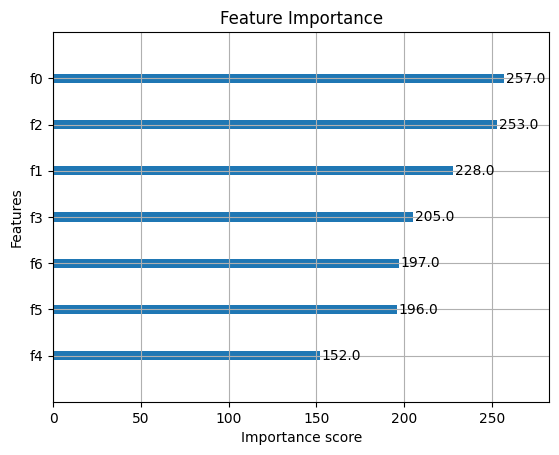

In [ ]:
model = xgb.XGBRegressor(**best_params, objective="reg:tweedie")

model.fit(X_train,y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Val RMSE: {test_rmse:.4f}")

# # Feature Importance Plot
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=7)  # Show top 10 features
plt.title("Feature Importance")
plt.show()

In [ ]:
X_test=df_test[['Price','Past_Purchase_Trends', 'Competitor_Price', 'effective_price', 'price_sensitivity', 'comp_impact','year_sine']]

In [130]:
X_test_scaled = scaler.transform(X_test)

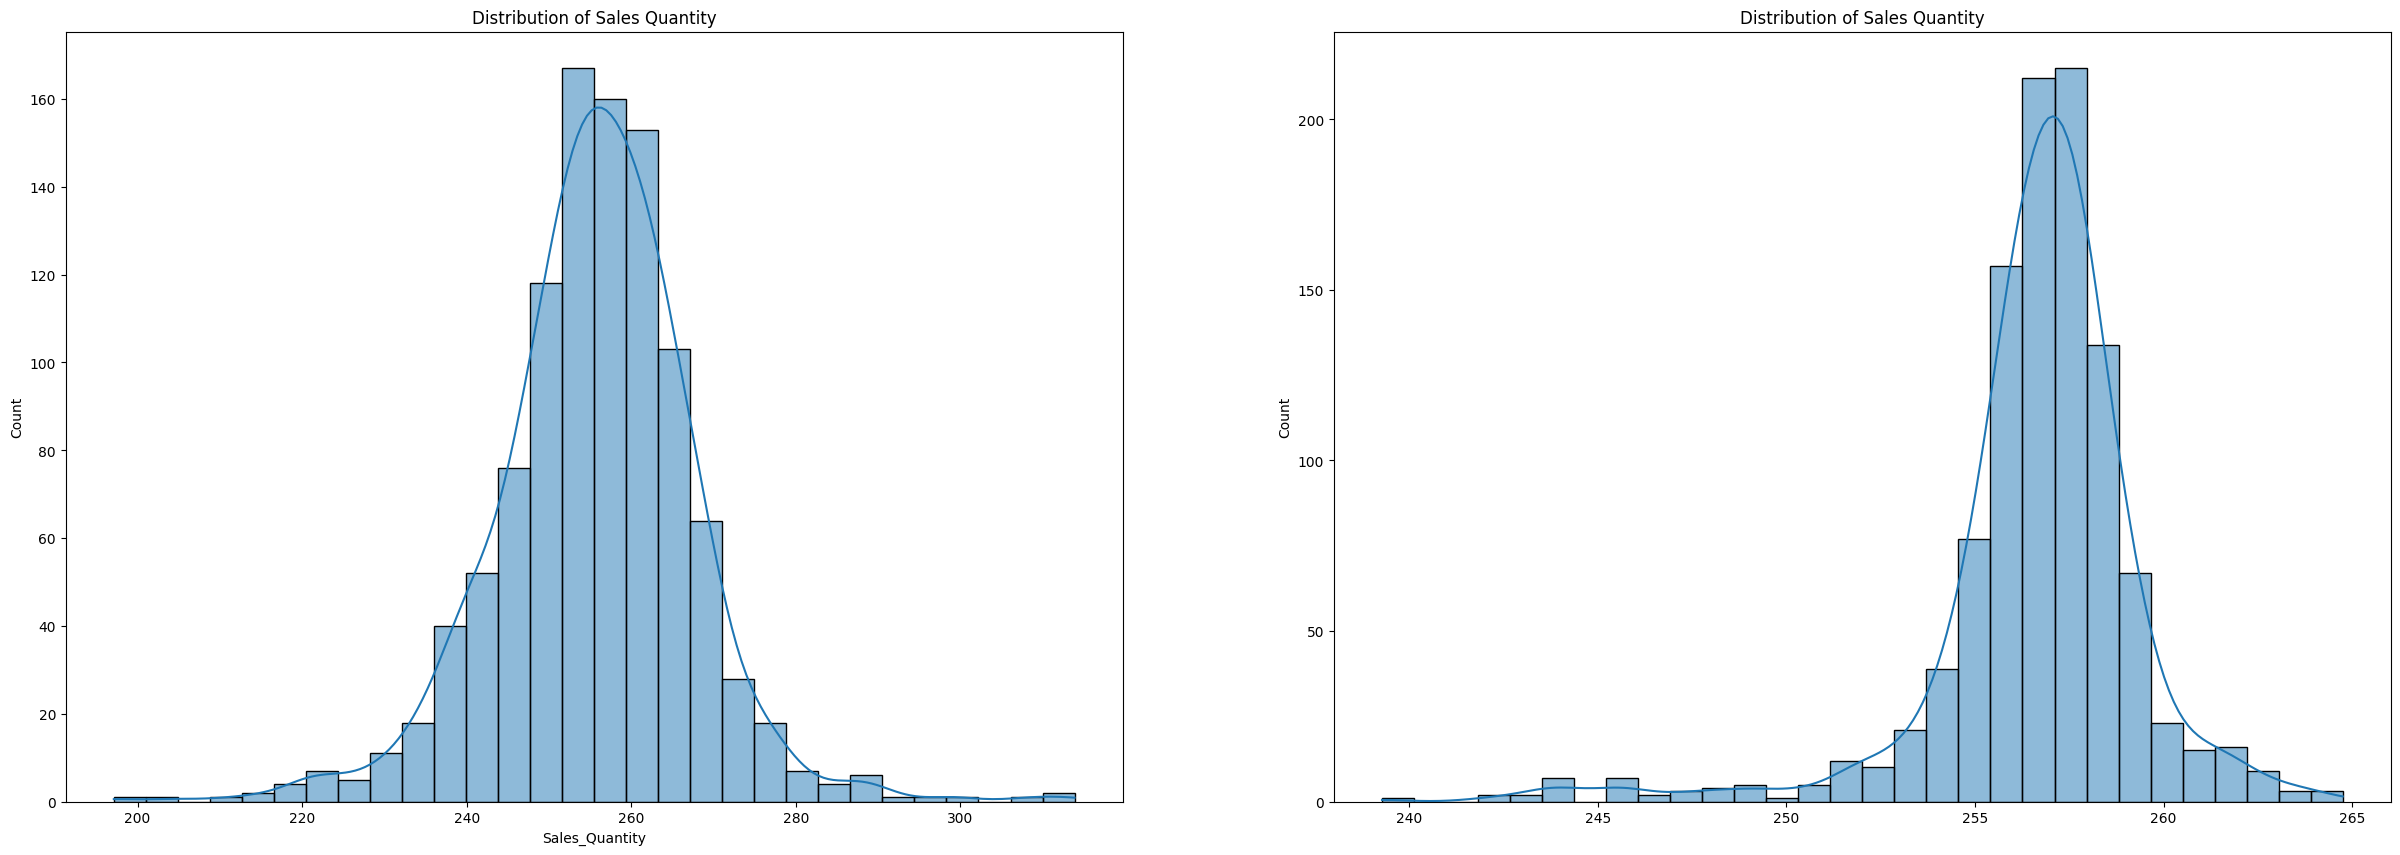

In [131]:
plt.figure(figsize=(30,10))

plt.subplot(121)
df1=pd.read_csv("predictions8.csv")
sns.histplot(df1["Sales_Quantity"], kde=True, bins=30)
plt.title("Distribution of Sales Quantity")


y_pred = model.predict(X_test_scaled)
plt.subplot(122)
sns.histplot(y_pred, kde=True, bins=30)
plt.title("Distribution of Sales Quantity")
plt.show()

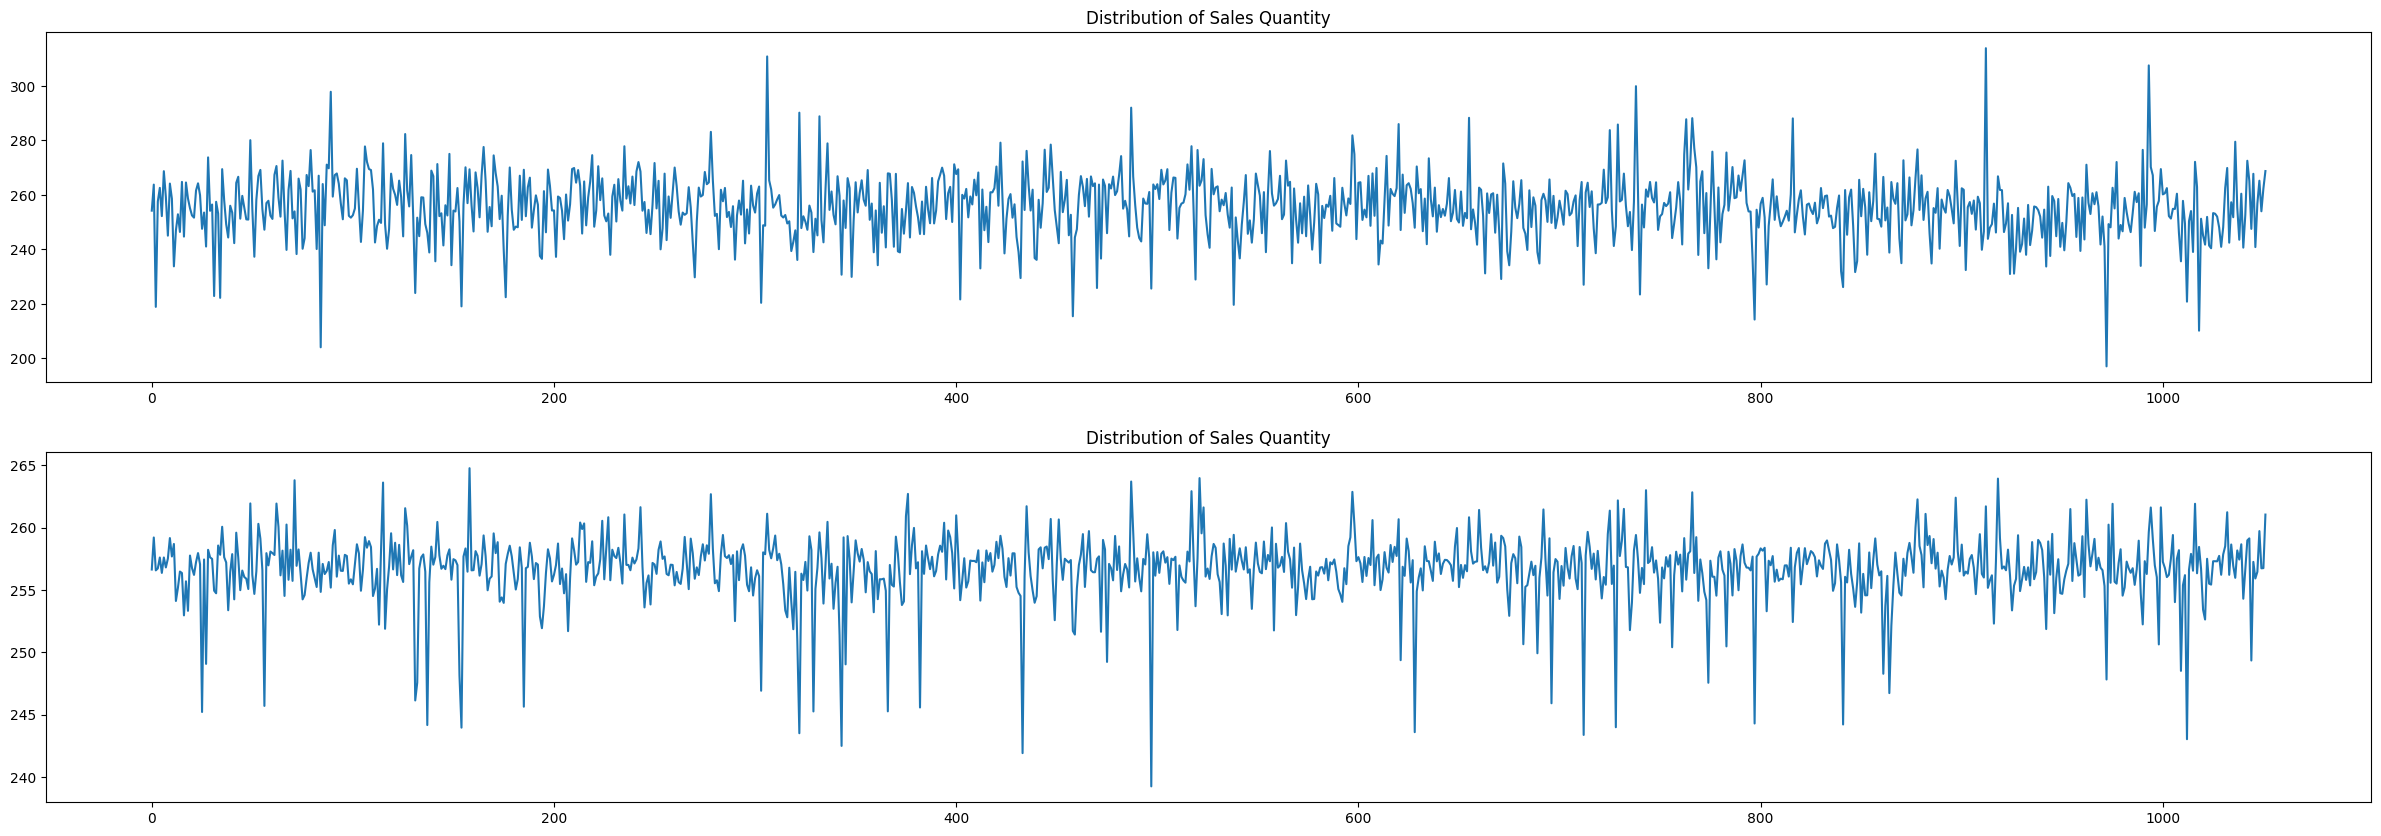

In [132]:
plt.figure(figsize=(30,10))

plt.subplot(211)
df1=pd.read_csv("predictions8.csv")
plt.plot(df1["Sales_Quantity"])
plt.title("Distribution of Sales Quantity")

plt.subplot(212)
plt.plot(y_pred)
plt.title("Distribution of Sales Quantity")
plt.show()

In [133]:
len(y_pred)

1052

In [134]:
prediction=pd.DataFrame()
prediction["Sales_Quantity"] = y_pred
prediction.to_csv("predictions9.csv", index=False)

In [135]:
"""
pred8 is the best one yet

Train RMSE: 138.1304
Val RMSE: 137.9135
"""

'\npred8 is the best one yet\n\nTrain RMSE: 138.1304\nVal RMSE: 137.9135\n'